In [2]:
import json
import pandas as pd 

In [3]:
ls ../data/results/vanilla_interleav_matched_dist.json

../data/results/vanilla_interleav_matched_dist.json


In [14]:
ground_truth_results = json.load(open('../data/v3_sources/v3_combined_ALL_with_oracle.json'))
ground_truth = pd.DataFrame(ground_truth_results)
full_ground_truth_df = (
    ground_truth
         .explode('truth')
         .reset_index(drop=True)
         .pipe(lambda df: pd.concat([df[['query']], pd.DataFrame(df['truth'].tolist())], axis=1))
)

In [16]:
# ground_truth_df = (
#     full_ground_truth_df
#         .loc[lambda df: df['url'].isin(pred_df['url'])]
# )

In [17]:
vanilla_results = json.load(open('../data/results/pooled_vanilla_example.json'))

In [18]:
results_df = pd.DataFrame(vanilla_results)

In [19]:
# ground_truth_df = (
#     results_df[['url', 'query', 'truth']]
#          .explode('truth')
#          .reset_index(drop=True)
#          .pipe(lambda df: pd.concat([df[['url', 'query']], pd.DataFrame(df['truth'].tolist())], axis=1))
# )

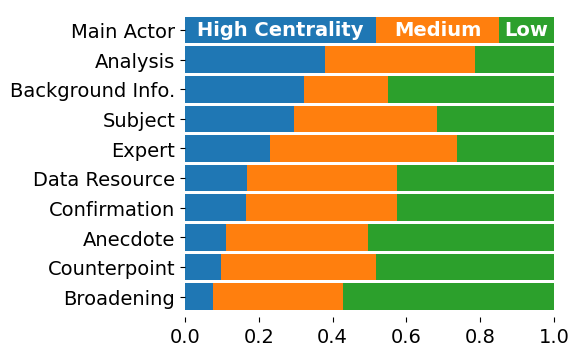

In [297]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)
f, ax = plt.subplots(1, 1, figsize=(5,4))
df_to_plot = (
    (full_ground_truth_df
         .groupby('llama_label')['Centrality']
         .value_counts()
         .unstack()
        )
         .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
         .sort_values('High', ascending=False)[['High', 'Medium', 'Low']]
        .iloc[::-1]
)

(
df_to_plot
 .rename(index={
    'Anecdotes, Examples and Illustration': 'Anecdote',
    'Confirmation and Witness': 'Confirmation',
    'Background Information': 'Background Info.',
    'Broadening Perspective': 'Broadening'
 })
 .plot(
    kind='barh',
    stacked=True,
    width=0.9,  # Reduces space between bars
    ax=ax
 )
)

# Add white text labels inside the bars
for i, (index, row) in enumerate(df_to_plot.iterrows()):
    if (i==len(df_to_plot)- 1):
        cum_width = 0  # Track cumulative width for positioning labels
        for j, (col_name, value) in enumerate(row.items()):
            if j == 0:
                to_display = col_name + ' Centrality'
            else:
                to_display = col_name
            if (value > 0):  # Only add labels for non-zero values
                ax.text(
                    cum_width + value / 2,  # Position the label at the center of the bar segment
                    i,  # Row index (y-axis)
                    # f"{col_name}: {value:.2f}",  # Text to display
                    to_display,
                    va='center', ha='center',  # Center alignment
                    color='white', fontsize=14, weight='bold'
                )
                cum_width += value  # Update cumulative width

# Hide the legend since labels are inside bars
plt.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel('')
plt.savefig('../latex/naacl2024/figures/centrality_discourse.png', bbox_inches='tight')
# .pipe(lambda df: df.divide(df.sum(axis=0), axis=1))
 # .assign(Total=lambda df: df.sum(axis=1))

In [20]:
pred_df = (
    results_df[['url', 'query', 'dr_sources']]
        .explode('dr_sources')
        .reset_index(drop=True)
        .pipe(lambda df: pd.concat([df[['url', 'query']], pd.DataFrame(df['dr_sources'].tolist())], axis=1))
        .assign(orig_doc_url=lambda df: df['id'].str.split('#').str.get(0))
        .assign(Name=lambda df: df['id'].str.split('#').str.get(1))
)

pred_df['rank'] = pred_df.groupby(['url', 'query'])['score'].transform('rank', ascending=False)
pred_df = (pred_df
 .merge(
     full_ground_truth_df[['url', 'Name', 'Perspective', 'Centrality', 'llama_label']], 
     right_on=['url', 'Name'], 
     left_on=['orig_doc_url', 'Name'], 
     # left_on=['url', 'Name'], 
     # how='left'
 )
 .drop(columns='url_y')
 .rename(columns={'url_x': 'url'})
)

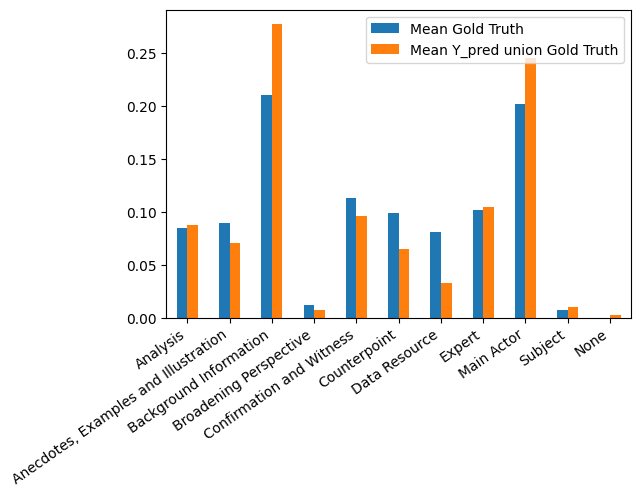

In [365]:
import matplotlib.pyplot as  plt

mean_ground_truth = (
    ground_truth_df
         .groupby('url')['llama_label']
         .value_counts()
         .unstack()
         .fillna(0)
         .pipe(lambda df: df.divide(df.sum(axis=1), axis=0)).mean().to_frame('Mean Gold Truth')
)

overall_ground_truth_dist = (
        ground_truth_df['llama_label']
             .value_counts()
             .pipe(lambda s: s /s.sum()).round(2).to_frame('Overall Gold Truth')
    )

overall_y_pred_discourse_dict = (
        pred_df
             .loc[lambda df: df['rank'] < 10]
             .loc[lambda df: df['url'] == df['orig_doc_url']]
             ['oracle_label'].value_counts()
             .pipe(lambda s: s /s.sum()).round(2)
             .to_frame('Y_pred union Gold Truth')
)


mean_y_pred_discourse_dict = (
        pred_df
             .loc[lambda df: df['rank'] < 10]
             .loc[lambda df: df['url'] == df['orig_doc_url']]
             .groupby('url')['oracle_label']
                 .value_counts()
                 .unstack()
                 .fillna(0)
                 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0)).mean().to_frame('Mean Y_pred union Gold Truth')
    
)

ax = pd.concat([
    # (
    #     pred_df
    #          .loc[lambda df: df['rank'] < 10]['oracle_label']
    #          .value_counts()
    #          .pipe(lambda s: s / s.sum())
    #          .round(2)
    #          .to_frame('Interleaving Predictions')
    # ),
    mean_ground_truth,
    # overall_ground_truth_dist,
    # mean_y_pred_discourse_dict
    
], axis=1).plot(kind='bar', figsize=(6,4))
plt.xticks(rotation=35, horizontalalignment='right');

In [415]:
from sklearn.metrics import f1_score

In [454]:
import numpy as np 
def safe_div(prec, recall):
    denominator = prec + recall
    numerator = 2 * prec * recall
    
    # Use np.where to safely handle division by zero
    f1 = np.where(denominator == 0, 0, numerator / denominator)
    return f1


def safe_div_2(prec, recall):
    f1s =[] 
    for p, r in zip(prec, recall):
        denominator = p + r
        numerator = 2 * p * r
    
        # Use np.where to safely handle division by zero
        f1 = 0 if np.isclose(denominator, 0) else numerator / denominator 
        f1s.append(f1)
    return f1s
    
df = (
    pred_df
         .loc[lambda df: df['rank'] < 11]
         .assign(precision=lambda df: df['url'] == df['orig_doc_url'])
         .merge(ground_truth_df[['url', 'Name']].assign(ground_truth=1), how='outer')
         .assign(recall=lambda df: df['ground_truth'].fillna(0))
         .groupby('url')
         [['precision', 'recall']]
         .mean()
         .assign(f1=lambda df: safe_div_2(df['precision'], df['recall']))
)

In [528]:
pred_at_k_df = (
    pred_df
     .loc[lambda df: df['rank'] < 11]
     .merge(
         full_ground_truth_df[['url', 'Name', 'Perspective', 'Centrality', 'llama_label']].loc[lambda df: df['url'].isin(pred_df['url'])],
         how='outer',
         on=['url', 'Name'],
         suffixes=('__retrieved_doc_label', '__gold_truth_doc_label')
       )
)

ret_cols = [
    'Perspective__retrieved_doc_label',
    'Centrality__retrieved_doc_label',
    'llama_label__retrieved_doc_label'
]

non_ret_cols = [
    'Perspective__gold_truth_doc_label',
    'Centrality__gold_truth_doc_label',
    'llama_label__gold_truth_doc_label'
]

for r_c, n_r_c in zip(ret_cols, non_ret_cols):
    c = r_c.split('__')[0]
    pred_at_k_df[c] = pred_at_k_df[r_c].combine_first(pred_at_k_df[n_r_c])

pred_at_k_df = pred_at_k_df.drop(columns=non_ret_cols + ret_cols)

In [567]:
pred_at_k_df

t = (
    pred_at_k_df
         .groupby('Perspective')
         .apply(lambda df: 
             df
                 .assign(precision=lambda df: df['url'] == df['orig_doc_url'])
                 .merge(ground_truth_df[['url', 'Name']].assign(ground_truth=1), how='outer')
                 .assign(recall=lambda df: df['ground_truth'].fillna(0))
                 .groupby('url')
                 [['precision', 'recall']]
                 .mean()
                 .assign(f1=lambda df: safe_div_2(df['precision'], df['recall']))
                 )
).groupby(level=0).mean()#.loc[['High', 'Medium', 'Low']].astype(float)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_80492/763391151.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df:


In [568]:
t

,precision,recall,f1
Perspective,,,
Against,0.136366,0.933750,0.165584
Authoritative,0.204396,0.895780,0.239115
Informative,0.167828,0.729103,0.217279
Neutral,0.216266,0.870837,0.258833
Skeptical,0.137255,0.973296,0.144000
Supportive,0.219667,0.866923,0.258047


In [569]:
print(t.astype(float).sort_values('f1', ascending=False).round(2).to_csv(sep='\t'))

Perspective	precision	recall	f1
Neutral	0.22	0.87	0.26
Supportive	0.22	0.87	0.26
Authoritative	0.2	0.9	0.24
Informative	0.17	0.73	0.22
Against	0.14	0.93	0.17
Skeptical	0.14	0.97	0.14



In [379]:
(
    pred_df
         .loc[lambda df: df['rank'] < 10]
         .loc[lambda df: df['url'] == df['orig_doc_url']]
         ['Centrality']
         .value_counts()
         # ['oracle_label'].value_counts()
         # .pipe(lambda s: s /s.sum()).round(2)
         # .to_frame('Y_pred \ union Gold Truth')
)

Centrality
High      236
Medium    199
Low       120
Name: count, dtype: int64

In [411]:
ground_truth_df['Centrality'].value_counts()[['High', 'Medium','Low']]

Centrality
High      461
Medium    620
Low       624
Name: count, dtype: int64

In [367]:
ground_truth_df['llama_label'].value_counts()

llama_label
Background Information                  326
Main Actor                              322
Anecdotes, Examples and Illustration    201
Counterpoint                            195
Confirmation and Witness                175
Expert                                  167
Analysis                                148
Data Resource                           139
Broadening Perspective                   20
Subject                                  11
Name: count, dtype: int64

In [21]:
from langdetect import detect as detect_language
from tqdm.auto import tqdm
tqdm.pandas()

query_languages = full_ground_truth_df['query'].drop_duplicates().progress_apply(detect_language)

  0%|          | 0/51044 [00:00<?, ?it/s]

In [22]:
full_ground_truth_df = (
    full_ground_truth_df
        .loc[lambda df: df['query'].isin(df['query'].drop_duplicates().loc[query_languages=='en'])]
)

In [23]:
sample_articles = full_ground_truth_df['url'].drop_duplicates().sample(5_000)

In [24]:
sample_to_score = full_ground_truth_df.loc[lambda df: df['url'].isin(sample_articles)]

In [26]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
source_embeddings = model.encode(sample_to_score['Information'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1148 [00:00<?, ?it/s]

In [ ]:
queries_to_score = sample_to_score['query'].drop_duplicates()
query_embeddings = model.encode(queries_to_score.tolist(), show_progress_bar=True)

In [144]:
sample_to_score

,query,url,Name,Biography,Information,Narrative Function,Perspective,Centrality,Is_Error,Justification,Text_embed,llama_label,query_source_cos_sim
75,Are Airbnb's security measures sufficient to p...,www.ibtimes.co.uk/airbnb-scammers-hijack-user-...,Airbnb CTO Nathan Blecharczyk,The Chief Technology Officer of Airbnb,Nathan Blecharczyk stated that trust is the fu...,"""Official Response"": This source is used to pr...",Authoritative,High,No,Nathan Blecharczyk is a high-ranking executive...,The Chief Technology Officer of Airbnb: Nathan...,Main Actor,0.663759
76,Are Airbnb's security measures sufficient to p...,www.ibtimes.co.uk/airbnb-scammers-hijack-user-...,A victim of the scam,A person who was robbed after leasing their ho...,The victim said that he was burgled after leas...,"""Victim's Voice"": This source provides a perso...",Informative,Medium,No,The victim's testimony provides a personal acc...,A person who was robbed after leasing their ho...,"Anecdotes, Examples and Illustration",0.378668
77,Are Airbnb's security measures sufficient to p...,www.ibtimes.co.uk/airbnb-scammers-hijack-user-...,BBC,A British public service broadcaster,BBC reported that at least three people said t...,"""Third-Party Verification"": This source is use...",Informative,Medium,No,The BBC is cited as a source for the number of...,A British public service broadcaster: BBC repo...,Confirmation and Witness,0.633215
78,Are Airbnb's security measures sufficient to p...,www.ibtimes.co.uk/airbnb-scammers-hijack-user-...,Airbnb's official Facebook page,The official Facebook page of Airbnb,Airbnb's official Facebook page is filled with...,"""Evidence of Widespread Problem"": This source ...",Informative,Low,No,The Facebook page is mentioned as a place wher...,The official Facebook page of Airbnb: Airbnb's...,"Anecdotes, Examples and Illustration",0.626379
79,Are Airbnb's security measures sufficient to p...,www.ibtimes.co.uk/airbnb-scammers-hijack-user-...,Nathan Blecharczyk,Airbnb CTO,Nathan Blecharczyk stated that trust is the fu...,"""Company Representative"": This source is used ...",Authoritative,High,No,Nathan Blecharczyk is the CTO of Airbnb and is...,Airbnb CTO: Nathan Blecharczyk stated that tru...,Main Actor,0.667577
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379211,Will the recent undercover video exposing crue...,www.motherjones.com/food/2014/01/pork-giant-ty...,The article's author (unnamed),The author of the article,The author stated that when people see what go...,"""Narrator"": This source is used to guide the r...",Supportive,High,No,The article's author is supportive of the move...,The author of the article: The author stated t...,Analysis,0.448714
379289,Will the surge in online shopping during the 2...,www.forbes.com/sites/toddwasserman/2020/11/24/...,Todd Wasserman,A veteran ad industry journalist with a fondne...,Todd Wasserman stated that the term Shippagedd...,"""Author/Interviewer"": ""This source is used to ...",Neutral,High,No,Todd Wasserman is the author of the article an...,A veteran ad industry journalist with a fondne...,Background Information,0.738018
379290,Will the surge in online shopping during the 2...,www.forbes.com/sites/toddwasserman/2020/11/24/...,David Kear,VP of warehouse operations for CarParts.com,David Kear stated that the increase in online ...,"""Expert/Insider"": ""This source is used to prov...",Informative,High,No,David Kear is the VP of warehouse operations f...,VP of warehouse operations for CarParts.com: D...,Expert,0.627214
379291,Will the surge in online shopping during the 2...,www.forbes.com/sites/toddwasserman/2020/11/24/...,UPS,A shipping company,UPS has sent out a reminder of shipping deadli...,"""Counterpoint"": ""This source is used to provid...",Informative,Low,No,UPS is mentioned as a shipping company that ha...,A shipping company: UPS has sent out a reminde...,Counterpoint,0.438280


In [145]:
from sklearn.metrics.pairwise import cosine_similarity

source_emb_df = pd.DataFrame(source_embeddings)
source_emb_df[['query', 'url', 'Name', 'Perspective', 'Centrality', 'llama_label']] = sample_to_score[['query', 'url', 'Name', 'Perspective', 'Centrality', 'llama_label']].reset_index(drop=True)

query_emb_df = pd.DataFrame(query_embeddings)
query_emb_df['query'] = queries_to_score.reset_index(drop=True)

In [88]:
query_source_emb_df = (
    query_emb_df
         .merge(sample_to_score[['url', 'query', 'Name']])
         .merge(source_emb_df, on=['url', 'query', 'Name'], suffixes=('_query', '_source'))
)

In [90]:
query_emb_cols = list(filter(lambda x: '_query' in x, query_source_emb_df.columns))
source_emb_cols = list(filter(lambda x: '_source' in x, query_source_emb_df.columns))

In [97]:
from scipy.spatial.distance import cosine
cos_sims = query_source_emb_df.progress_apply(lambda x: 1 - cosine(x[query_emb_cols], x[source_emb_cols]) ,axis=1)

  0%|          | 0/36718 [00:00<?, ?it/s]

In [101]:
sample_to_score['query_source_cos_sim'] = cos_sims.tolist()

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_95394/2916565452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_to_score['query_source_cos_sim'] = cos_sims.tolist()


In [104]:
sample_to_score.groupby('Centrality')['query_source_cos_sim'].mean()[['High', 'Medium', 'Low']]

Centrality
High      0.593993
Medium    0.474511
Low       0.412945
Name: query_source_cos_sim, dtype: float64

In [113]:
groups = source_emb_df.groupby('url')

In [248]:
all_doc_sims = []
for idx, df in tqdm(groups):
    doc_source_embs = df.drop(columns=['query', 'url', 'Name'])
    doc_source_sim_df = (
        pd.DataFrame(
            cosine_similarity(doc_source_embs),
            index=df['Name'].tolist(), columns=df['Name'].tolist()
            ).unstack()
             .reset_index()
             .rename(columns={'level_0': 'source_1', 'level_1': 'source_2', 0: 'cosine_sim'})
    )
    
    doc_sims = (doc_source_sim_df
     .merge(df[['url', 'Name']], left_on=['source_1',], right_on='Name')
     .drop(columns='Name'))
    all_doc_sims.append(doc_sims)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [250]:
all_doc_sims_df = pd.concat(all_doc_sims)

In [251]:
all_doc_sims_df.groupby('url')

,source_1,source_2,cosine_sim,url
0,The article's author (unnamed),The article's author (unnamed),1.000000,5gindia.economist.com/
1,The article's author (unnamed),Lou Auguste,0.216647,5gindia.economist.com/
2,The article's author (unnamed),Qualcomm,0.375443,5gindia.economist.com/
3,The article's author (unnamed),Narendra Modi,0.488469,5gindia.economist.com/
4,The article's author (unnamed),The Indian government,0.607243,5gindia.economist.com/
...,...,...,...,...
59,AVD Reform,The team of Dr. Barbiero,0.165219,wwwrm1.ansa.it/canale_saluteebenessere/notizie...
60,AVD Reform,Catia Cecchini,0.142230,wwwrm1.ansa.it/canale_saluteebenessere/notizie...
61,AVD Reform,Stone Center in Veneto,0.154221,wwwrm1.ansa.it/canale_saluteebenessere/notizie...
62,AVD Reform,Senup,0.175552,wwwrm1.ansa.it/canale_saluteebenessere/notizie...


In [258]:
(
all_doc_sims_df
 .loc[lambda df: df['source_1'] != df['source_2']]
    ['cosine_sim'].mean()
)

0.40045762

In [261]:
(
all_doc_sims_df
    .loc[lambda df: df['source_1'] != df['source_2']]
    ['cosine_sim'].pipe(lambda s: s > .7)
    .value_counts().pipe(lambda s: s/s.sum())
)

cosine_sim
False    0.926764
True     0.073236
Name: count, dtype: float64

In [256]:
(
all_doc_sims_df
 .loc[lambda df: df['source_1'] != df['source_2']]
 ['cosine_sim'].round(1)
 .value_counts()
 .sort_index().pipe(lambda s: s /s.sum())
)

cosine_sim
-0.2    0.000034
-0.1    0.002312
 0.0    0.024997
 0.1    0.077323
 0.2    0.134561
 0.3    0.180241
 0.4    0.189839
 0.5    0.166452
 0.6    0.113734
 0.7    0.062454
 0.8    0.028141
 0.9    0.013830
 1.0    0.006082
Name: count, dtype: float64

# Try extracting questions from sources

In [146]:
import re
import ast
import pyperclip
import pprint
import os
from together import Together

client = Together(api_key=open('/Users/spangher/.togetherai-usc-key.txt').read().strip())
def query_together(prompt, client=client):
    response = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        messages=[{
                    "role": "system",
                    "content": "You are an experienced journalist."
                },
                {
                    "role": "user",
                    "content": prompt
                }],
        max_tokens=1048,
        temperature=0.1,
        top_p=0.7,
        top_k=50,
        repetition_penalty=1,
        stop=["<|eot_id|>","<|eom_id|>"],
    )
    return response.choices[0].message.content

In [147]:
article_text = pd.read_json('cache/test_sources__article_text__263000_263500.txt', lines=True)

In [148]:
article_text['article_text'] = article_text['response'].str.replace('`', '').str.strip()

In [169]:
queries_with_articles = (
    full_ground_truth_df
        .merge(article_text[['url', 'article_text']])
        [['query', 'url', 'article_text', 'Name', 'Text_embed', 'llama_label']]
        # [['query', 'url', 'article_text', 'Text_embed', 'llama_label']]
)

In [172]:
query

"Are Facebook's content moderation policies being applied inconsistently in India, particularly with regards to hate speech from Hindu nationalist politicians, and is the company's leadership adequately addressing these concerns?"

In [173]:
pd.options.display.max_colwidth = 200

In [200]:
queries_with_articles['query'].drop_duplicates()

0                                                                   Are Chip and Joanna Gaines responding to recent divorce rumors amidst their latest business venture, a home and lifestyle line with Target?
4       Are Facebook's content moderation policies being applied inconsistently in India, particularly with regards to hate speech from Hindu nationalist politicians, and is the company's leadership adequ...
15                                                                                                Are Target stores open on Labor Day 2020, and what changes can customers expect due to the COVID-19 pandemic?
20      Are U.S. companies, particularly those in the tech industry, inadvertently aiding China's bid for dominance in the semiconductor sector through investments and partnerships, potentially underminin...
23                             Are companies starting to use unconventional methods, such as mobile games, to recruit and attract young talent, and is this approach eff

In [218]:
import pyperclip
idx = 1
query = queries_with_articles['query'].drop_duplicates().iloc[idx]
print(query)
example = (queries_with_articles
 .loc[lambda df: df['query']==query]
 .drop(columns=['article_text', 'url', 'query'])
 .rename(columns={'Text_embed': 'Source text', 'llama_label': 'Discourse Label'})
 # .to_dict(orient='records')
)

Are Facebook's content moderation policies being applied inconsistently in India, particularly with regards to hate speech from Hindu nationalist politicians, and is the company's leadership adequately addressing these concerns?


In [222]:
import pyperclip
pyperclip.copy(example.to_latex(index=False))

In [228]:
definitions_df = pd.Series({
    "Anecdotes, Examples and Illustration": "Real-world stories of every-day people being affected by events in the story.",
    "Main Actor": "Individuals or entities involved in decision-making that effects events in the story.",
    "Subject": "Individuals or entities being affected/targeted by events in the story.",
    "Background Information": "Provides broader context to events, helping readers understand the main topic in the context of what is going on and grasp peripheral details.",
    "Broadening Perspective": "Induces the reader to think about the events of the news article in new or bigger picture.",
    "Analysis": "These sources offer insights and forecasts, often explaining what things mean going forward.",
    "Counterpoint": "These sources offer diverse perspectives or examples of differences, opposing opinions to provide a more balanced understanding.",
    "Expert": "These sources provide essential facts, rules or interpretations to help us understanding the events.",
    "Confirmation and Witness": "Someone whose role is primarily to confirm events that occurred in the news article. ",
    "Data Resource": "These sources provide statistics and other survey or scientific resources."
})

In [236]:
# print(definitions_df.to_frame('Definition').reset_index().to_latex(index=False))

In [576]:
PROMPT = """
Here is a news article: 

```{news_article}```

Imagine you were the journalist who wrote this story. Here is a source included in the article:

```{source}```

Why do you think they reached out to this source? What question do you think information from this source would answer, in terms of the broader themes of the story and the source's identity? How does this source fit into the story? 
Respond with just the question.
"""
# Imagine you are the journalist who wrote this story.
# What pieces of information in the story do you think they were trying to answer when they talked to this?

# might have about this story and it's broader themes that would lead you to this source?
#  trying to think about what source to talk to. 
# In the context of the article, what is broader thematic questions that this source answers? 

PROMPT_2 = """
Here is an initial query: 

```{query}```

Imagine you are the journalist trying to write a story based on this query. Here is a source:

```{source}```

What question do you think information from this source would answer, in terms of the broader themes of the story and the source's identity?
Respond with just the question.
"""

In [577]:
idx = 0

In [578]:
queries_with_articles.loc[14:].iloc[idx]['query']

'Is the Republican National Committee violating a 1982 settlement by collaborating with the Trump campaign on poll-watching activities, as suggested by recent statements from Trump representatives?'

In [579]:
queries_with_articles.loc[14:].iloc[idx]['Text_embed']

"A federal judge of the U.S. District Court of New Jersey: Judge John Michael Vazquez ordered the Republican National Committee to explain in detail whether it is running any poll-watching or 'ballot security' operations in conjunction with Donald Trump's presidential campaign, and to submit or explain any agreements that it has with Mr. Trump's campaign, written or oral, by Wednesday evening."

In [580]:
queries = []
for _, row in queries_with_articles.loc[14:].iterrows():
    prompt = PROMPT.format(news_article=row['article_text'], source=row['Text_embed'])
    # prompt = PROMPT.format(query=row['query'], source=row['Text_embed'])
    r = query_together(prompt)
    queries.append(r)

In [581]:
queries

['What specific actions is the court taking to address allegations of potential RNC violations of a 1982 settlement, and what information is the court seeking from the RNC regarding its activities with the Trump campaign?',
 'What is the nature of the relationship between the Republican National Committee and Donald Trump\'s presidential campaign regarding poll-watching or "ballot security" operations, and how does it relate to the 1982 settlement?',
 'What evidence is there that the RNC is collaborating with the Trump campaign on poll-watching activities, potentially violating a 1982 settlement, as suggested by a high-ranking official within the Trump campaign?',
 'What evidence is there that the RNC is collaborating with the Trump campaign on poll-watching activities, potentially violating a 1982 settlement, as suggested by statements from high-ranking Trump campaign officials like Mike Pence?',
 'What steps has the RNC taken internally to ensure compliance with the 1982 settlement, 

In [ ]:
t = queries_with_articles.loc[14:].copy().reset_index(drop=True)
t['source_query'] = queries

In [408]:
# t[['Text_embed', 'llama_label', 'source_query']].to_dict(orient='records')

In [ ]:
prompt = (
    queries_with_articles
     .iloc[idx]
     .pipe(lambda df: 
        PROMPT.format(news_article=df['article_text'], source=df['Text_embed'])
          )
)

# Slop

In [380]:
counts = """ainonline              1658
airwaysmagazine        1285
arstechnica            2693
bleacherreport         5835
breitbartnews         14736
chessbase              2083
cnet                   5130
denverpost            10960
foxnews               55441
jaxdotcom              5908
jessicavalenti          241
jezebel                6573
motherjones            1695
newsobserver           9825
nytimes               49737
phoenixluc              364
rollcall               1751
seattletimes          18494
sfchronicle            4616
sinow                   359
slate                 10480
startelegram           8247
studyfindsorg          1251
thealligator           2146
theathletic           22548
thedailyclimate        6755
thehill               24999
weatherchannel         4705
wired                  3461
wsj                   18827
yaledailynews           964""".split('\n')
counts = list(map(lambda x: x.split(), counts))

In [393]:
counts_df = pd.DataFrame(counts, columns=['outlet', 'counts']).assign(counts=lambda df: df['counts'].astype(int))

In [389]:
f1_scores = pd.read_csv('/Users/spangher/Downloads/clean_text_evaluation.csv')

In [399]:
f1_scores[['outlet', 'trial']] = f1_scores['outlet_model'].str.split('_', expand=True).rename(columns={0:'outlet', 1:'trial'})

In [402]:
f1_scores.merge(counts_df)[['f1', 'counts']].corr()

,f1,counts
f1,1.000000,-0.046686
counts,-0.046686,1.000000


<Axes: >

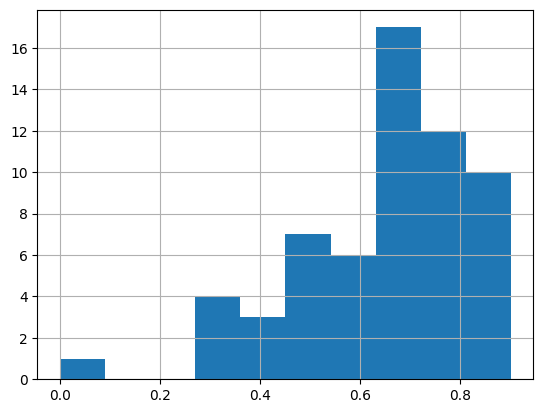

In [407]:
import seaborn as sns
# sns.boxplot(f1_scores['f1'])
f1_scores['f1'].hist()